In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Simplex'

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.0018211156681


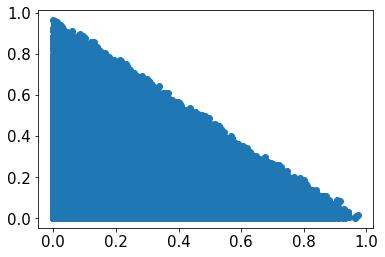

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10

S = generate_uniform_points_in_simplex(NumberofSources, N)

print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))
plt.scatter(S[0,:], S[1,:])

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

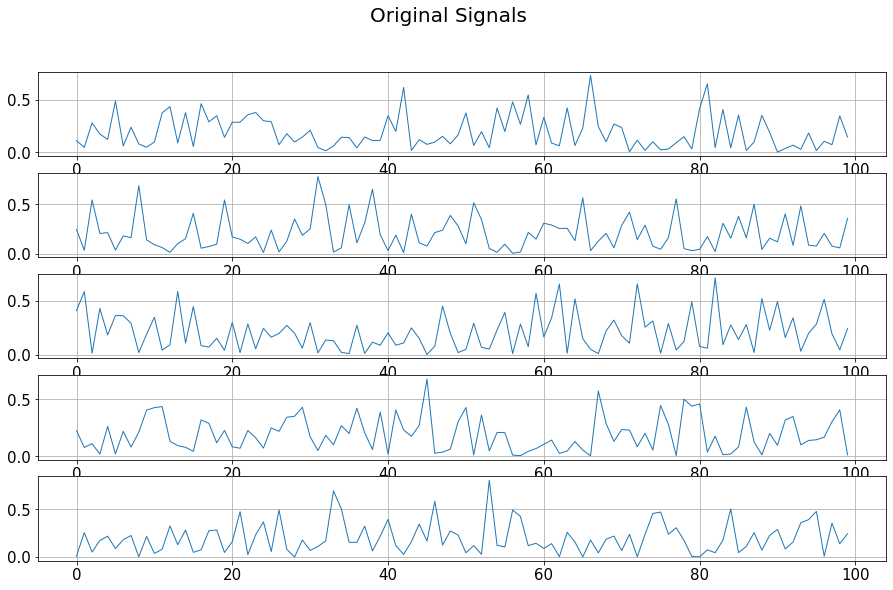

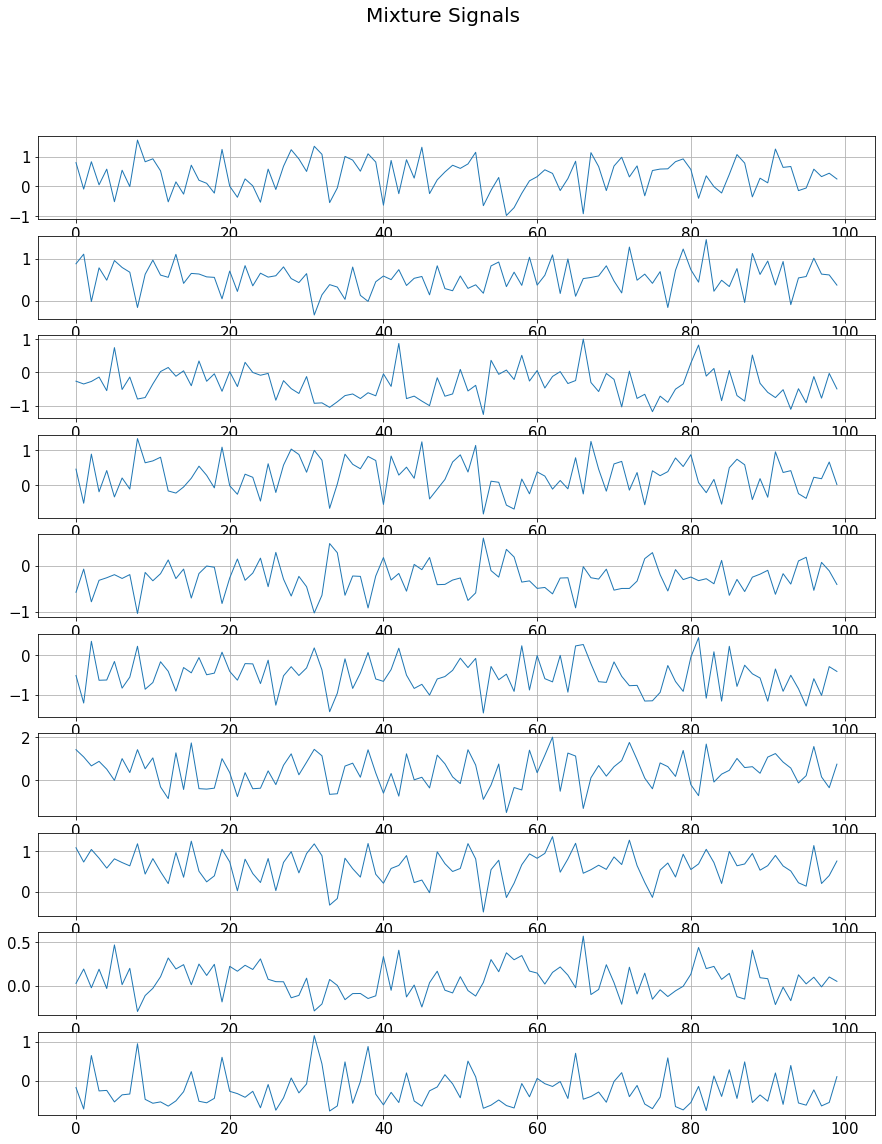

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [5]:
S.sum(axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [6]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-1/10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

debug_iteration_point = 25000
model = OnlineCorInfoMax(s_dim = s_dim, x_dim = x_dim, muW = 30*1e-3, lambday = lambday,
                         lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                         set_ground_truth = True, S = S, A = A)

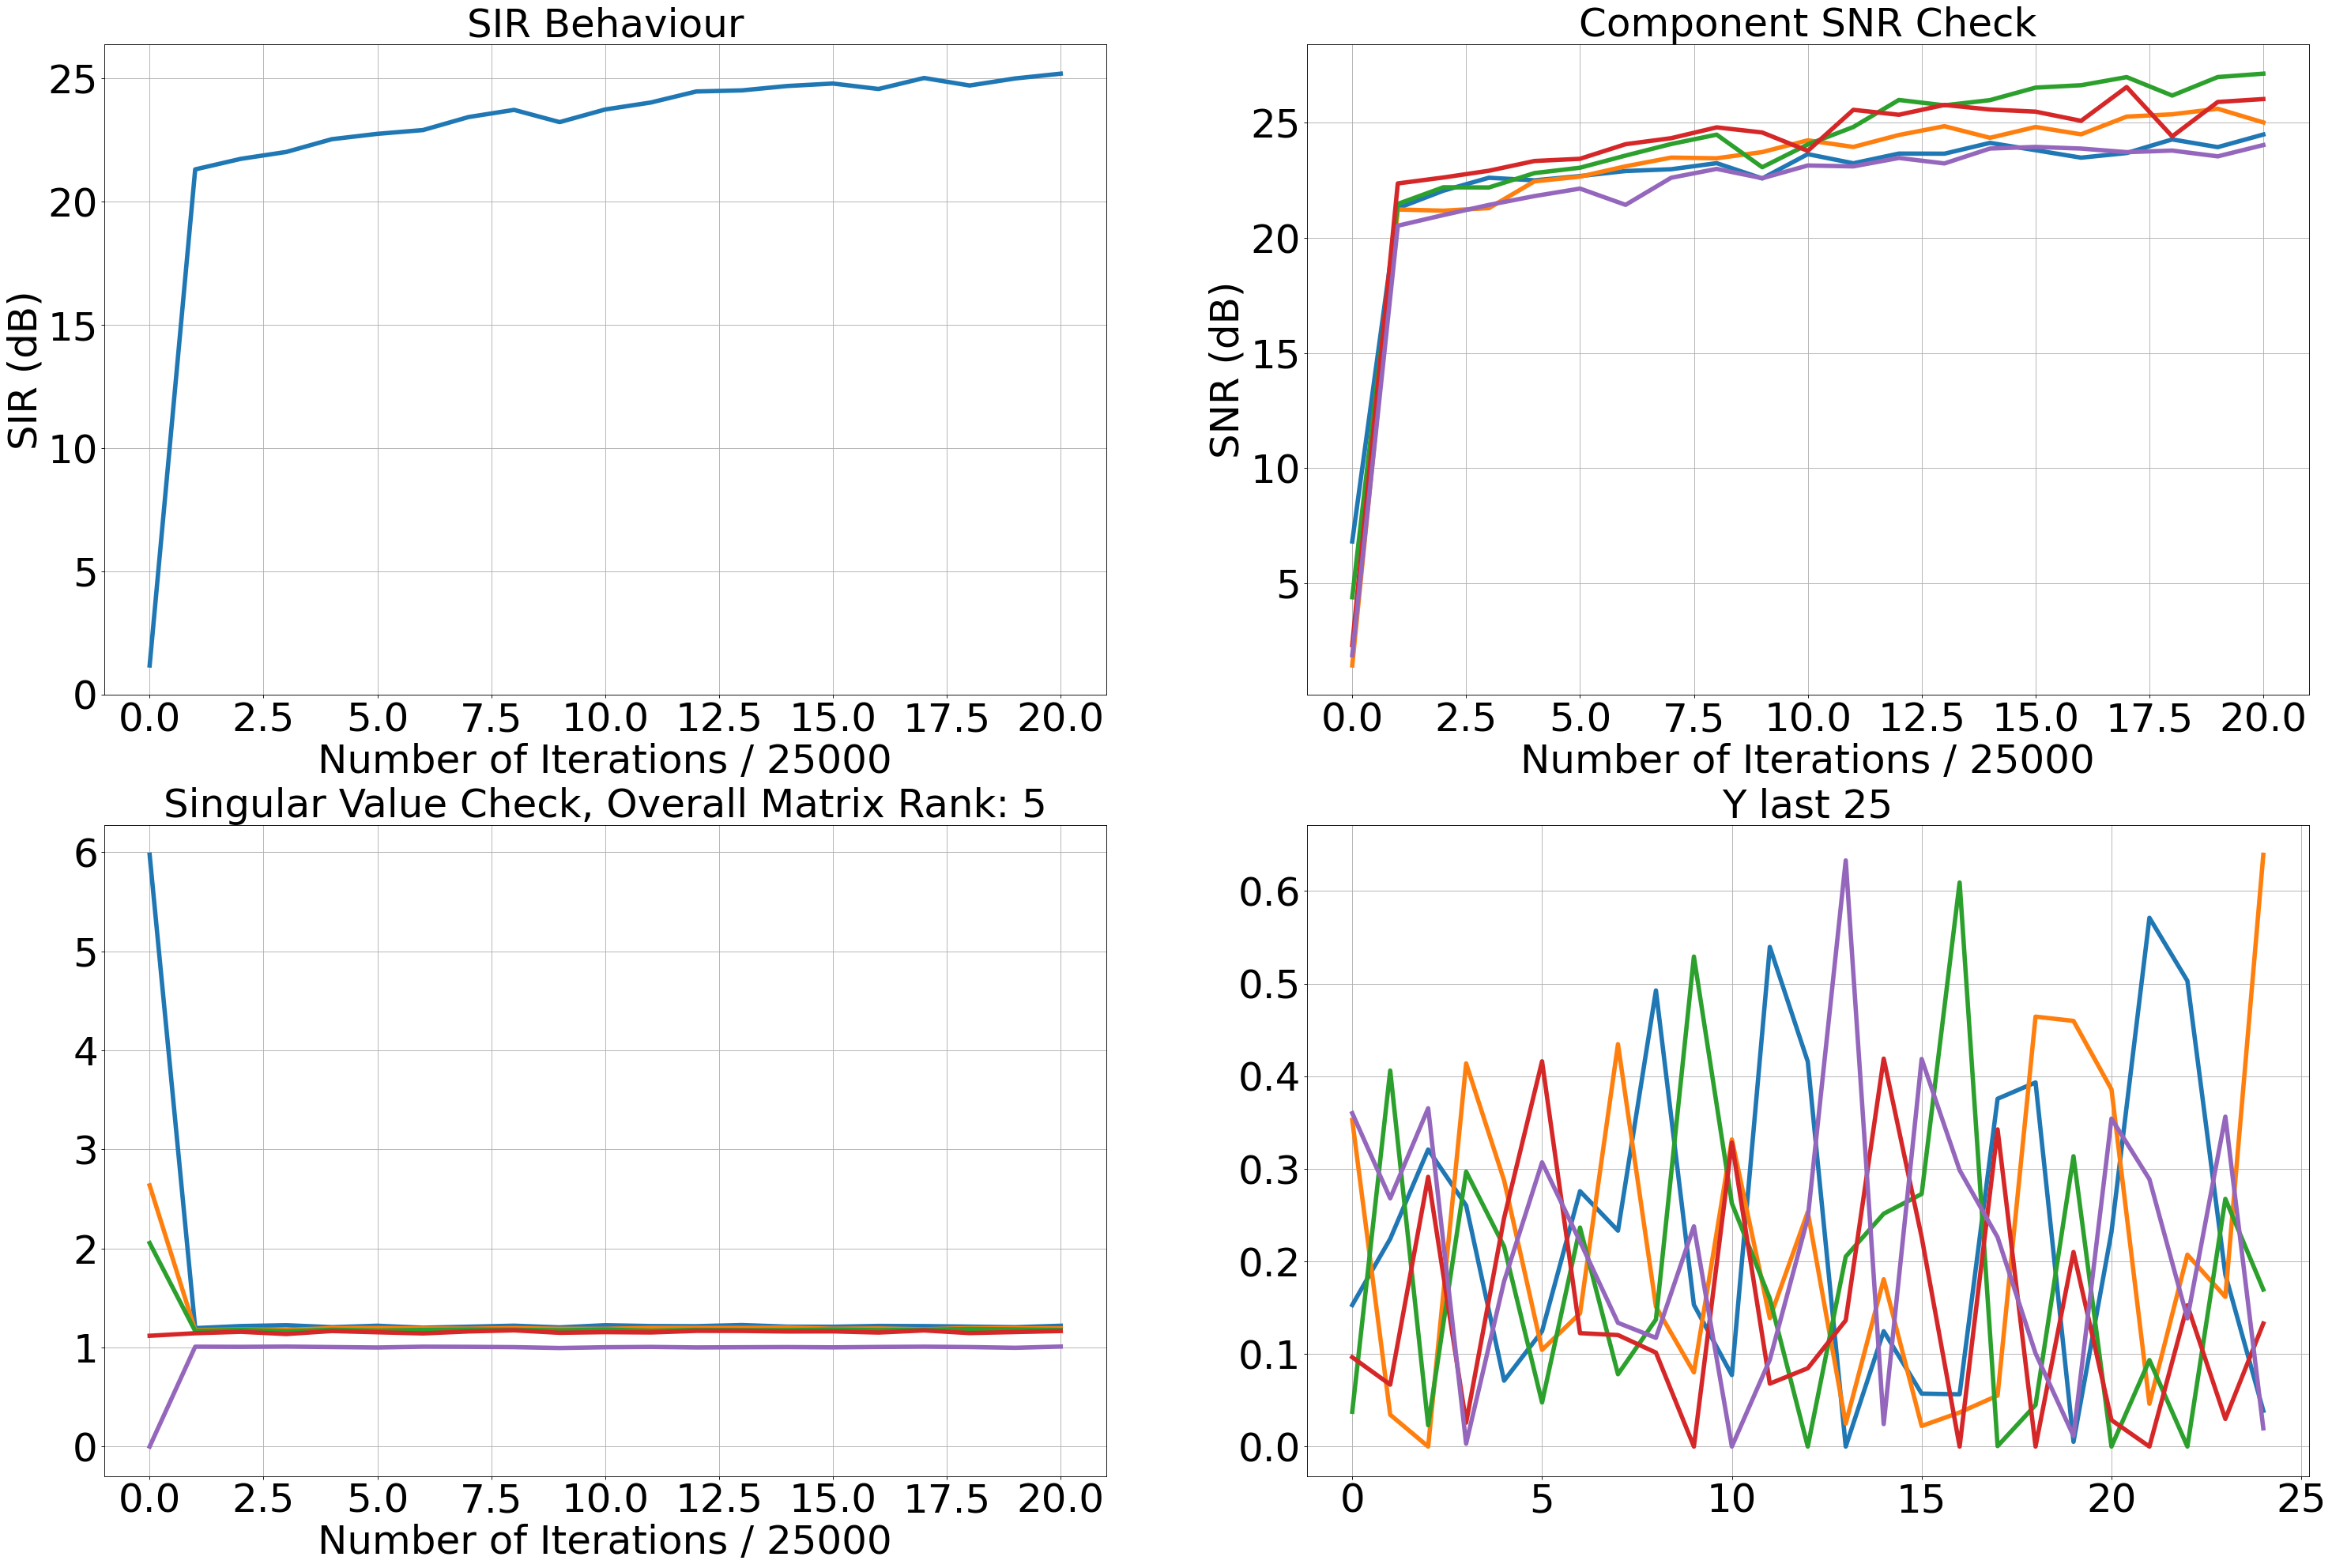

100%|██████████| 500000/500000 [09:21<00:00, 891.07it/s] 


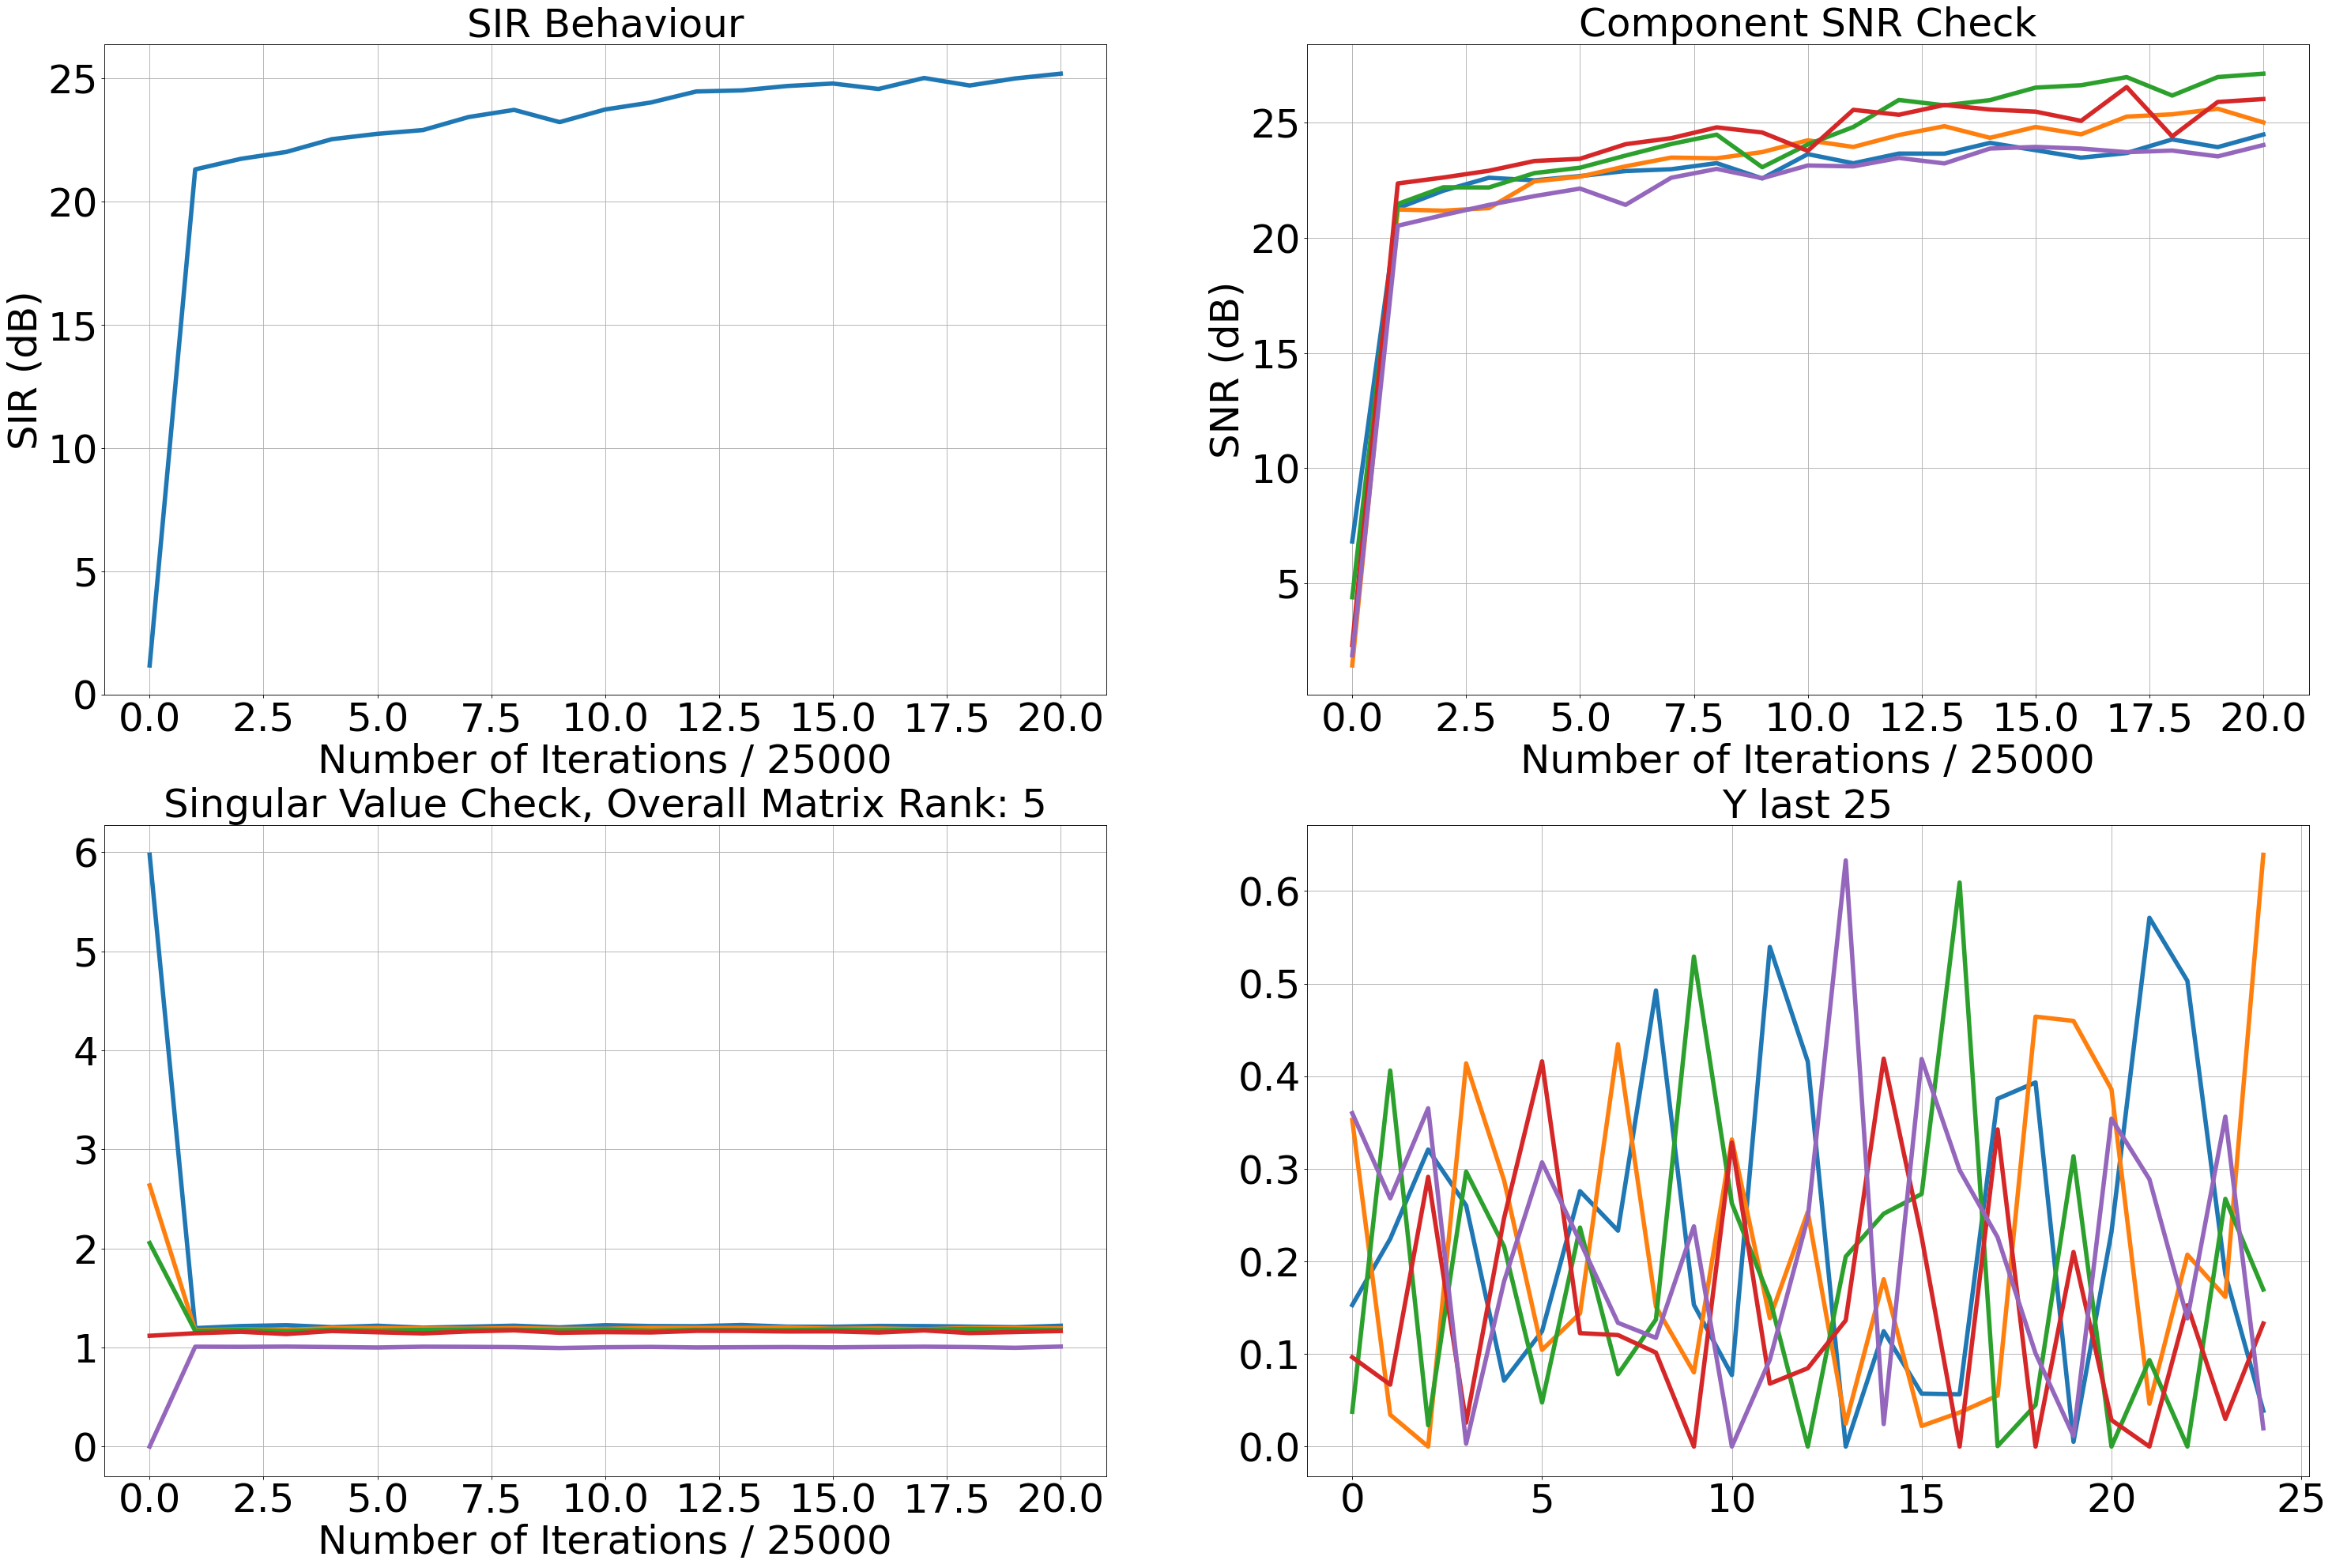

In [7]:
model.fit_batch_simplex(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                         plot_in_jupyter = True, neural_lr_start = 0.1,
                         neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                         shuffle = True)

Final SIR: 25.191823535403493


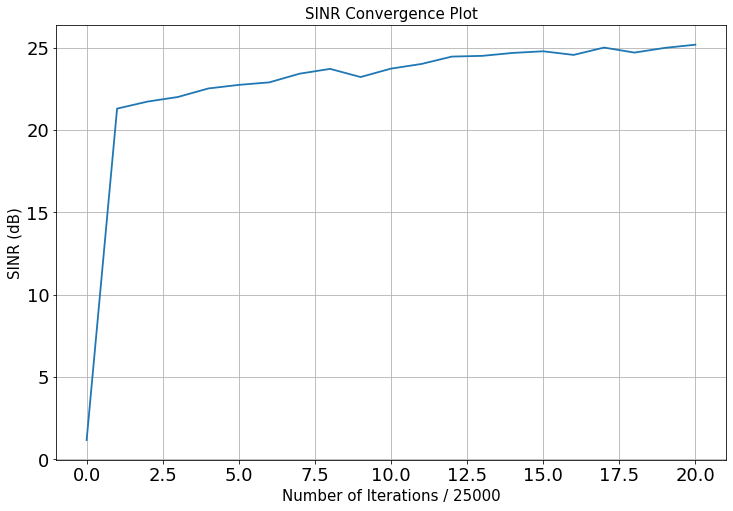

In [8]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SIR: {}'.format(np.array(model.SIR_list[-1])))

In [9]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean,Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, Szeromean, False)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [24.49096519 25.01775451 27.13621595 26.0327133  24.03284935]

Overall SINR : 25.191823535403493


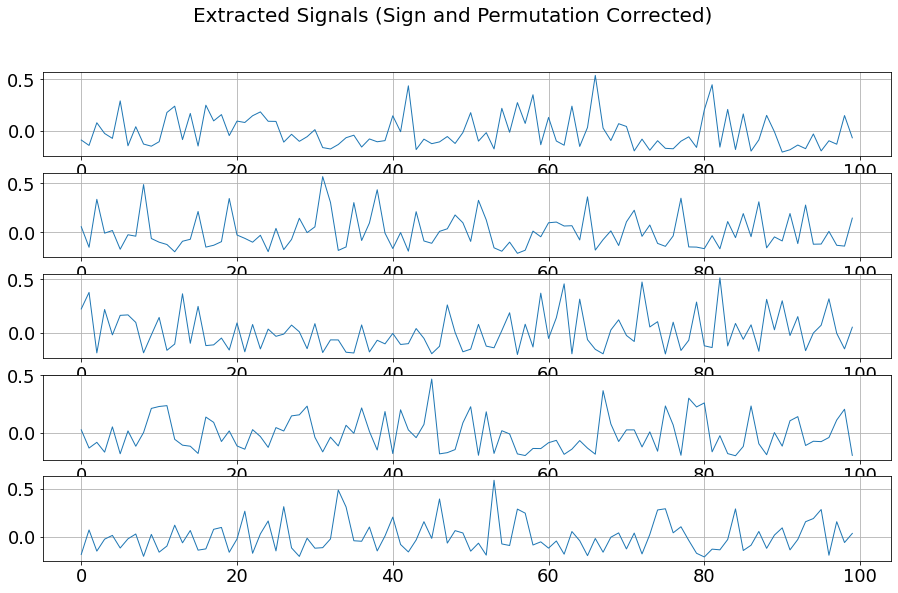

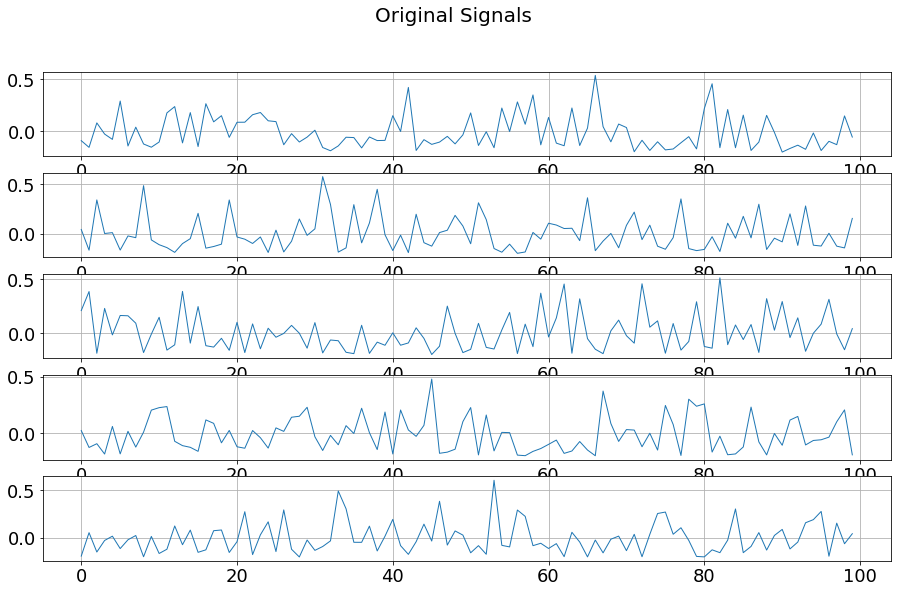

In [10]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(Szeromean[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [11]:
import mir_eval

In [12]:
S.shape, Y_.shape

((5, 500000), (5, 500000))

In [13]:
mir_eval.separation.bss_eval_sources(S, Y_,
                     compute_permutation=True)

(array([21.92882203, 22.23246634, 23.25691214, 22.64963452, 21.61316471]),
 array([25.28783688, 24.72987499, 25.2229799 , 24.63304675, 24.69434018]),
 array([24.62917171, 25.83903318, 27.65780889, 27.02229558, 24.56843734]),
 array([0, 1, 2, 3, 4]))